### Q1. Spatial structural analysis is widely used to analyse the influence range of a given phenomenon. In the attached IMERG_HHL folder, you can find 30-min IMERG precipitation data for period of 2009/08/07 00:00 – 2009/08/09 00:00. Your tasks here are to perform spatial analyses and to calculate the characteristic range of Typhoon Morakot for the period it passed Taiwan (i.e. 2009/08/07 17:00 – 2009/08/08 08:00 UTC time) based upon the algorithm proposed in Ochoa-Rodriguez et al. (2015) (see Section 3.2.1 in the paper). 

### Ochoa-Rodriguez et al. (2015): https://www.sciencedirect.com/science/article/pii/S0022169415003856


### Your specific tasks are:


In [12]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
import netCDF4 as nc

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

#### 1.1. (15%) Derive climatological sample variogram using attached data files for the period of 2009/08/07 15:00 – 2009/08/08 08:00 (including image at 2009/08/08 08:00). Note that please use ‘degree’ directly as distance (if you use gstools, 'latlon=False' in vario_estimate)

In [13]:
# You may run the main loop here to:
# 1. import rainfall data from each file
import glob
list_of_paths = glob.glob('./Data/IMERG-HHL/*.nc4', recursive=True)
# list_of_paths[30] # check the image time for 8/7 15:00
# list_of_paths[64] # check the image time for 8/8 08:00
container = np.zeros((35,41,51)) # Make a 35 by 41 by 51 array, 65=time steps from 8/7 15:00
for i in range(30, 65):
    nc_fid = nc.Dataset(f'{list_of_paths[i]}')
    # in nc_fid.variables we know that precipitationalCal have 3 dimensions but for only one time step [0,:,:]
    rain = nc_fid.variables['precipitationCal'][:,:,:]
    container[i-30,:,:] = rain


# check the dimensions and variables
# nc_fid.dimensions
# nc_fid.variables

# define value
lat = nc_fid.variables['lat'][:]
lon = nc_fid.variables['lon'][:]

# check the shape of 3d arrray
print(container.shape)
print(lat.shape)

(35, 41, 51)
(51,)


(51, 41)


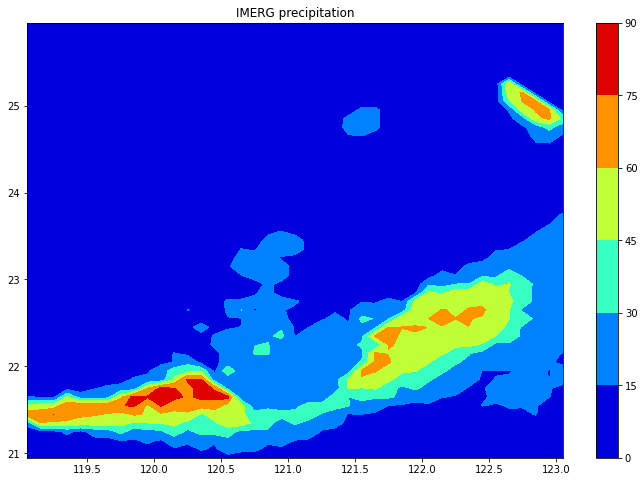

In [14]:
# plot precipitationCal of every time step to check the 
rain_map = container[25,:,:].copy()

# Do transpose to move 'lon' to the 2nd dimension, and 'lat' to the 1st dimension
rain_map = rain_map.T
print(rain_map.shape)

plt.rcParams["figure.figsize"] = (12,8)

# Use contourf to plot rain_map
plt_ctrl=plt.contourf(lon,lat,rain_map)
plt.colorbar(plt_ctrl,orientation='vertical')
plt.title('IMERG precipitation')
plt.set_cmap(cmap=plt.get_cmap('jet'))

In [6]:
# 2. compute and 'normalise' sample variogram and collect them in a list-like container
# get every time step's variogram
list_variogram = []
for i in range(0,35):
    field = container[i].T.ravel()
    # in order to let the xpos and ypos have the same with rain value
#     xpos, ypos = np.meshgrid(lon, lat, indexing="ij")
    xpos, ypos = np.meshgrid(lon, lat)
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    # Empirical variogram
    bin_center, gamma = gs.vario_estimate((xpos, ypos), field, latlon=False)
    # Normalised gamma(variogram) by corresponding sample variance (range won't change)
    gamma_nor = gamma/np.var(field)
    list_variogram.append(gamma_nor)

In [5]:
# You may 'average' the normalised variograms here
sum_variogram = np.sum(list_variogram, axis=0)
# print(sum_variogram)

# create a climatological sample variogram
climatological_var = sum_variogram/35
print(f'Climatological Sample Variogram: {climatological_var}')
print(f'Bin Center: {bin_center}')

[ 0.          3.96217984  6.92691498  9.59766197 12.1205649  14.38808704
 16.25767564 17.94666337 19.23911805 20.31706097 21.4217834  22.40617262
 23.35850072 24.14452506 24.78768678 25.46134106 26.19650559 26.79420694
 27.4045895  28.08890894 28.80039193 29.55314477 30.33340866 31.21628228]
Climatological Sample Variogram: [0.         0.11320514 0.19791186 0.27421891 0.34630185 0.4110882
 0.46450502 0.51276181 0.54968909 0.58048746 0.61205095 0.64017636
 0.66738573 0.68984357 0.70821962 0.72746689 0.74847159 0.76554877
 0.78298827 0.80254026 0.82286834 0.84437556 0.86666882 0.89189378]
Bin Center: [0.04446614 0.13339842 0.2223307  0.31126298 0.40019526 0.48912755
 0.57805983 0.66699211 0.75592439 0.84485667 0.93378895 1.02272123
 1.11165351 1.20058579 1.28951808 1.37845036 1.46738264 1.55631492
 1.6452472  1.73417948 1.82311176 1.91204404 2.00097632 2.08990861]


In [6]:
# a = container[12].T.ravel()
# # in order to let the xpos and ypos have the same with rain value
# xpos, ypos = np.meshgrid(lon, lat, indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()

In [7]:
# Empirical variogram
# bin_center, gamma = gs.vario_estimate((xpos, ypos), a, latlon=False)
# print(f'Bin center: {bin_center}')
# print(f'Gamma: {gamma}')
# # Normalised by corresponding sample variance
# gamma_nor = gamma/np.var(a)
# print(f'Normalised Gamma: {gamma_nor}')
# list_array = []
# list_array.append(gamma)
# list_array.append(gamma_nor)
# np.sum(list_array, axis=0)

#### 1.2. (5%) Fit this sample variogram with an exponential variogram model. Note that please use ‘degree’ directly as distance.

In [8]:
# Fit the sample variogram with an exponential variogram model
# Exponential variogram model is fitted to the climatological sample variogram
fit_model_exp = gs.Exponential(dim=2)
results, pcov = fit_model_exp.fit_variogram(bin_center, climatological_var, nugget=False)
fit_model_exp.fit_variogram(bin_center, climatological_var, nugget=False)

({'var': 0.9561849417993625, 'len_scale': 0.9160184999816048, 'nugget': 0.0},
 array([[0.00026779, 0.00053444],
        [0.00053444, 0.00118811]]))

#### 1.3. (5%) Plot the sample and fitted variograms in a single chart.

Exponential(dim=2, var=0.956, len_scale=0.916, nugget=0.0)
0.9160184999816048


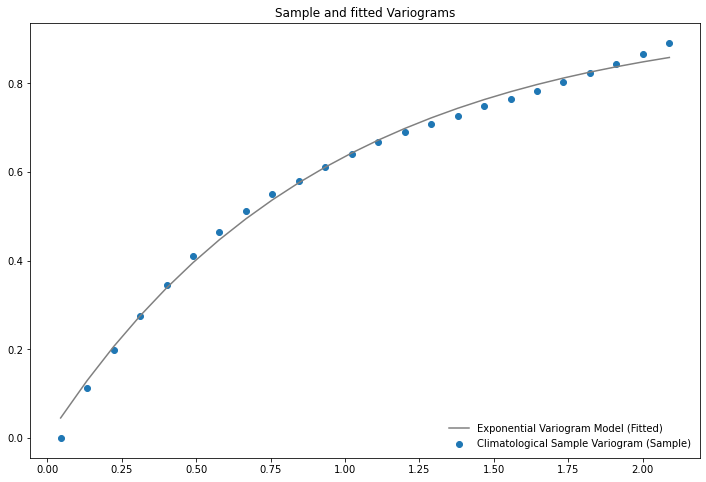

In [9]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(bin_center, fit_model_exp.variogram(bin_center), color='grey', label='Exponential Variogram Model (Fitted)')
ax.scatter(bin_center, climatological_var, label='Climatological Sample Variogram (Sample)')

plt.legend(frameon=False, loc='lower right')
plt.title('Sample and fitted Variograms')
print(fit_model_exp)
print(results['len_scale'])

#### 1.4. (5%) Derive the characteristic length (in degree).   

In [10]:
# calculate characteristic length
effective_range = results['len_scale']*3
characteristic_range = effective_range*0.836
characteristic_range

2.2973743979538646

#### 1.5. (5% bonus) You can get this bonus if you demonstrate that you can download IMERG HHL data files by yourself.

In [ ]:
# You may complete this task with python's 'requests' module
